# Module 2 Assessment
Welcome to the assessment for Module 2: Mapping for Planning. In this assessment, you will be generating an occupancy grid using lidar scanner measurements from a moving vehicle in an unknown environment. You will use the inverse scanner measurement model developed in the lessons to map these measurements into occupancy probabilities, and then perform iterative logodds updates to an occupancy grid belief map. After the car has gathered enough data, your occupancy grid should converge to the true map.

In this assessment, you will:
* Gather range measurements of a moving car's surroundings using a lidar scanning function.
* Extract occupancy information from the range measurements using an inverse scanner model.
* Perform logodds updates on an occupancy grids based on incoming measurements.
* Iteratively construct a probabilistic occupancy grid from those log odds updates.

For most exercises, you are provided with a suggested outline. You are encouraged to diverge from the outline if you think there is a better, more efficient way to solve a problem.
Launch the Jupyter Notebook to begin!

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import HTML

In this notebook, you will generate an occupancy grid based off of multiple simulated lidar scans. The inverse scanner model will be given to you, in the `inverse_scanner()` function. It returns a matrix of measured occupancy probability values based on the lidar scan model discussed in the video lectures. The `get_ranges()` function actually returns the scanned ranges value for a given vehicle position and scanner bearing. These two functions are given below. Make sure you understand what they are doing, as you will need to use them later in the notebook.

In [2]:
# Calculates the inverse measurement model for a laser scanner.
# It identifies three regions. The first where no information is available occurs
# outside of the scanning arc. The second where objects are likely to exist, at the
# end of the range measurement within the arc. The third are where objects are unlikely
# to exist, within the arc but with less distance than the range measurement.
def inverse_scanner(num_rows, num_cols, x, y, theta, meas_phi, meas_r, rmax, alpha, beta):
    '''
    inputs:
           (num_rows, num_cols): cells
           (x,y,theta): location and angle of the lidar
           (meas_phi, meas_r): measured bearing and range
           rmax: maximum detection range of lidar
           (alpha, beta): affected range and angle of the laser scan
    Outputs:
          m: Occupancy prabability P(m^i|x_t)
    '''
    m = np.zeros((M, N))
    for i in range(num_rows):
        for j in range(num_cols):
            # Find range and bearing relative to the input state (x, y, theta).
            r = math.sqrt((i - x)**2 + (j - y)**2)                                        # relative range 
            phi = (math.atan2(j - y, i - x) - theta + math.pi) % (2 * math.pi) - math.pi  # relative bearing
            
            # Find the range measurement associated with the relative bearing.
            k = np.argmin(np.abs(np.subtract(phi, meas_phi)))
            
            # If the range is greater than the maximum sensor range, or behind our range
            # measurement, or is outside of the field of view of the sensor, then no
            # new information is available.
            if (r > min(rmax, meas_r[k] + alpha / 2.0)) or (abs(phi - meas_phi[k]) > beta / 2.0):
                m[i, j] = 0.5
            
            # If the range measurement lied within this cell, it is likely to be an object.
            elif (meas_r[k] < rmax) and (abs(r - meas_r[k]) < alpha / 2.0):
                m[i, j] = 0.7
            
            # If the cell is in front of the range measurement, it is likely to be empty.
            elif r < meas_r[k]:
                m[i, j] = 0.3
                
    return m
                            

In [3]:
# Generates range measurements for a laser scanner based on a map, vehicle position,
# and sensor parameters.
# Uses the ray tracing algorithm.
def get_ranges(true_map, X, meas_phi, rmax):
    '''
    inputs:
            true_map: 1 means there is an obstacle
    '''
    (M, N) = np.shape(true_map)
    x = X[0]
    y = X[1]
    theta = X[2]
    meas_r = rmax * np.ones(meas_phi.shape)
    
    # Iterate for each measurement bearing.
    for i in range(len(meas_phi)):
        # Iterate over each unit step up to and including rmax.
        for r in range(1, rmax+1):
            # Determine the coordinates of the cell.
            xi = int(round(x + r * math.cos(theta + meas_phi[i])))
            yi = int(round(y + r * math.sin(theta + meas_phi[i])))
            
            # If not in the map, set measurement there and stop going further.
            if (xi <= 0 or xi >= M-1 or yi <= 0 or yi >= N-1):
                meas_r[i] = r
                break
            # If in the map, but hitting an obstacle, set the measurement range
            # and stop ray tracing.
            elif true_map[int(round(xi)), int(round(yi))] == 1:
                meas_r[i] = r
                break
                
    return meas_r

In the following code block, we initialize the required variables for our simulation. This includes the initial state as well as the set of control actions for the car. We also set the rate of rotation of our lidar scan. The obstacles of the true map are represented by 1's in the true map, 0's represent free space. Each cell in the belief map `m` is initialized to 0.5 as our prior probability of occupancy, and from that belief map we compute our logodds occupancy grid `L`.

In [4]:
# Simulation time initialization.
T_MAX = 150
time_steps = np.arange(T_MAX)

# Initializing the robot's location.
x_0 = [30, 30, 0]

# The sequence of robot motions.
u = np.array([[3, 0, -3, 0], [0, 3, 0, -3]])
u_i = 1

# Robot sensor rotation command
w = np.multiply(0.3, np.ones(len(time_steps)))

# True map (note, columns of map correspond to y axis and rows to x axis, so 
# robot position x = x(1) and y = x(2) are reversed when plotted to match
M = 50
N = 60
true_map = np.zeros((M, N))
true_map[0:10, 0:10] = 1
true_map[30:35, 40:45] = 1
true_map[3:6,40:60] = 1;
true_map[20:30,25:29] = 1;
true_map[40:50,5:25] = 1;

# Initialize the belief map.
# We are assuming a uniform prior.
m = np.multiply(0.5, np.ones((M, N)))

# Initialize the log odds ratio.
L0 = np.log(np.divide(m, np.subtract(1, m)))
L = L0

# Parameters for the sensor model.
meas_phi = np.arange(-0.4, 0.4, 0.05)
rmax = 30 # Max beam range.
alpha = 1 # Width of an obstacle (distance about measurement to fill in).
beta = 0.05 # Angular width of a beam.

# Initialize the vector of states for our simulation.
x = np.zeros((3, len(time_steps)))
x[:, 0] = x_0



Here is where you will enter your code. Your task is to complete the main simulation loop. After each step of robot motion, you are required to gather range data from your lidar scan, and then apply the inverse scanner model to map these to a measured occupancy belief map. From this, you will then perform a logodds update on your logodds occupancy grid, and update our belief map accordingly. As the car traverses through the environment, the occupancy grid belief map should move closer and closer to the true map. At the code block after the end of the loop, the code will output some values which will be used for grading your assignment. Make sure to copy down these values and save them in a .txt file for when your visualization looks correct. Good luck!

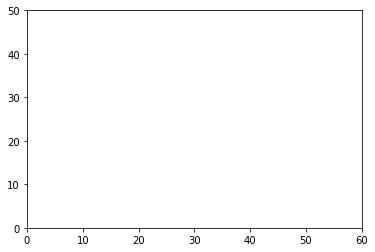

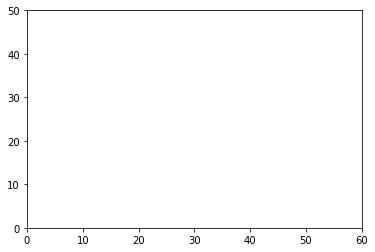

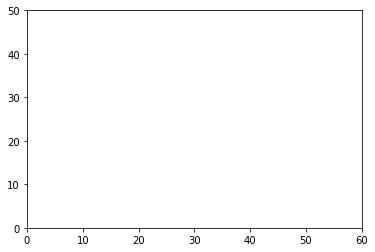

In [15]:
# capture
# Intitialize figures.
map_fig = plt.figure()
map_ax = map_fig.add_subplot(111)
map_ax.set_xlim(0, N)
map_ax.set_ylim(0, M)

invmod_fig = plt.figure()
invmod_ax = invmod_fig.add_subplot(111)
invmod_ax.set_xlim(0, N)
invmod_ax.set_ylim(0, M)

belief_fig = plt.figure()
belief_ax = belief_fig.add_subplot(111)
belief_ax.set_xlim(0, N)
belief_ax.set_ylim(0, M)

meas_rs = []
meas_r = get_ranges(true_map, x[:, 0], meas_phi, rmax)
meas_rs.append(meas_r)
invmods = []
invmod = inverse_scanner(M, N, x[0, 0], x[1, 0], x[2, 0], meas_phi, meas_r, \
                         rmax, alpha, beta)
invmods.append(invmod)
ms = []
ms.append(m)

# Main simulation loop.
for t in range(1, len(time_steps)):
    # Perform robot motion.
    move = np.add(x[0:2, t-1], u[:, u_i]) 
    # If we hit the map boundaries, or a collision would occur, remain still.
    if (move[0] >= M - 1) or (move[1] >= N - 1) or (move[0] <= 0) or (move[1] <= 0) \
        or true_map[int(round(move[0])), int(round(move[1]))] == 1:
        x[:, t] = x[:, t-1]
        u_i = (u_i + 1) % 4
    else:
        x[0:2, t] = move
    x[2, t] = (x[2, t-1] + w[t]) % (2 * math.pi)
    
    # TODO Gather the measurement range data, which we will convert to occupancy probabilities
    # using our inverse measurement model.
    meas_r = get_ranges(true_map, x[:,t-1], meas_phi, rmax)
    meas_rs.append(meas_r)
    
    # TODO Given our range measurements and our robot location, apply our inverse scanner model
    # to get our measure probabilities of occupancy.
    invmod = inverse_scanner(M, N, x[0,t-1], x[1,t-1], x[2,t-1], meas_phi, meas_r, rmax, alpha, beta)
    invmods.append(invmod)
    
    # TODO Calculate and update the log odds of our occupancy grid, given our measured
    # occupancy probabilities from the inverse model.
    L = L + np.log(invmod/(1-invmod))
    
    # TODO Calculate a grid of probabilities from the log odds.
    m = np.exp(L)/(1+np.exp(L))
    ms.append(m)
    


In [16]:
# Ouput for grading. Do not modify this code!
m_f = ms[-1]

print("{}".format(m_f[40, 10]))
print("{}".format(m_f[30, 40]))
print("{}".format(m_f[35, 40]))
print("{}".format(m_f[0, 50]))
print("{}".format(m_f[10, 5]))
print("{}".format(m_f[20, 15]))
print("{}".format(m_f[25, 50]))  

0.9857478005865102
0.9988631799564817
0.8448275862068965
0.5
0.07297297297297298
0.0002089976346871699
1.295301512798057e-06


Now that you have written your main simulation loop, you can visualize your robot motion in the true map, your measured belief map, and your occupancy grid belief map below. These are shown in the 1st, 2nd, and 3rd videos, respectively. If your 3rd video converges towards the true map shown in the 1st video, congratulations! You have completed the assignment. Please submit the output of the box above as a .txt file to the grader for this assignment.

In [17]:
def map_update(i):
    map_ax.clear()
    map_ax.set_xlim(0, N)
    map_ax.set_ylim(0, M)
    map_ax.imshow(np.subtract(1, true_map), cmap='gray', origin='lower', vmin=0.0, vmax=1.0)
    x_plot = x[1, :i+1]
    y_plot = x[0, :i+1]
    map_ax.plot(x_plot, y_plot, "bx-")

def invmod_update(i):
    invmod_ax.clear()
    invmod_ax.set_xlim(0, N)
    invmod_ax.set_ylim(0, M)
    invmod_ax.imshow(invmods[i], cmap='gray', origin='lower', vmin=0.0, vmax=1.0)
    for j in range(len(meas_rs[i])):
        invmod_ax.plot(x[1, i] + meas_rs[i][j] * math.sin(meas_phi[j] + x[2, i]), \
                       x[0, i] + meas_rs[i][j] * math.cos(meas_phi[j] + x[2, i]), "ko")
    invmod_ax.plot(x[1, i], x[0, i], 'bx')
    
def belief_update(i):
    belief_ax.clear()
    belief_ax.set_xlim(0, N)
    belief_ax.set_ylim(0, M)
    belief_ax.imshow(ms[i], cmap='gray', origin='lower', vmin=0.0, vmax=1.0)
    belief_ax.plot(x[1, max(0, i-10):i], x[0, max(0, i-10):i], 'bx-')
    
map_anim = anim.FuncAnimation(map_fig, map_update, frames=len(x[0, :]), repeat=False)
invmod_anim = anim.FuncAnimation(invmod_fig, invmod_update, frames=len(x[0, :]), repeat=False)
belief_anim = anim.FuncAnimation(belief_fig, belief_update, frames=len(x[0, :]), repeat=False)


In [18]:
HTML(map_anim.to_html5_video())

In [19]:
HTML(invmod_anim.to_html5_video())

In [20]:
HTML(belief_anim.to_html5_video())